In [1]:
%matplotlib inline

# Build mask creation data struct for use with shapely pypi

```python
wsi_annotation_sample_files = [  'class_label_csv_manager.py',
                                 'class_label_id.csv',
                                 '54742d6c5d704efa8f0814456453573a.xml',
                                 'e39a8d60a56844d695e9579bce8f0335.xml',
                                 'region_annotation.py' ]
```
## Shapely:
[Shapely GitHub](https://github.com/Toblerity/Shapely) <br>
[Shapely PyPi](https://pypi.org/project/Shapely/) <br>
[Shapely Documentation, Manual](https://shapely.readthedocs.io/en/latest/) <br>
[Actual Shapely Manual](https://shapely.readthedocs.io/en/stable/manual.html) <br>
[Shapely GIS stack-exchange](https://gis.stackexchange.com/questions/tagged/shapely) <br>
****

...`May Be Useful` <br>
[shapely object.bounds](https://shapely.readthedocs.io/en/latest/manual.html#object.bounds) <br>
[shapely object.contains](https://shapely.readthedocs.io/en/latest/manual.html#object.contains) <br>
[shapely object.centroid](https://shapely.readthedocs.io/en/latest/manual.html#object.centroid) <br>
[shapely object.intersects](https://shapely.readthedocs.io/en/latest/manual.html#object.intersects) <br>
[shapely object.envelope](https://shapely.readthedocs.io/en/latest/manual.html#object.envelope) <br>
[shapely object.overlaps](https://shapely.readthedocs.io/en/latest/manual.html#object.overlaps) <br>
[shapely object.touches](https://shapely.readthedocs.io/en/latest/manual.html#object.touches) <br>
[shapely object.union](https://shapely.readthedocs.io/en/latest/manual.html#object.union) <br>
[shapely object.within](https://shapely.readthedocs.io/en/latest/manual.html#object.within) <br>
****

[point, line, polygon](https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html) <br>
****

...`Noteworthy notebooks` <br>
[Auto-GIS](https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html) <br>

****
 ...`Peripherally Related` <br>
 [geo-whatever twilio (intro)](https://www.twilio.com/blog/2017/08/geospatial-analysis-python-geojson-geopandas.html) <br>
 [matplotlib plot shapely stuff: StackOverflow](https://stackoverflow.com/questions/55522395/how-do-i-plot-shapely-polygons-and-objects-using-matplotlib) <br>
****

...`Fully Acronym'ed Shapely` <br>
****
```python
"""
        wkt = well known text    ( format ) <br>
        wkb = well known binary  ( format ) <br>
"""
#      polygon is a list of tuples (not shapely points)
import geojson
import geopandas
import shapely
```


## try basic shapely:
```bash
# install shapely
pip3 install shapely
```

In [2]:
import os
import sys
from collections import defaultdict
import json

import xml.etree.ElementTree as ET
from xml.dom import minidom

import numpy as np
import pandas as pd

# import shapely
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

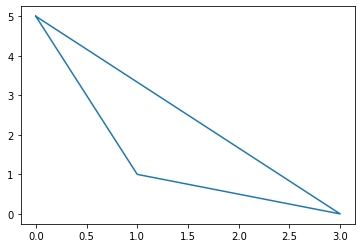

In [3]:
#                           a polygon is a list of tuples ----- (not shapely points)
polygon1 = Polygon([(0,5),
                    (1,1),
                    (3,0)])

x,y = polygon1.exterior.xy
plt.plot(x,y);
"""
plt.plot(*polygon1.exterior.xy) # ok ok ok
# plt.plot(polygon1)   no! no! no!
"""
plt.show()

# Convert xml input to a class_label_id dict of shapely polygons
## and display for developer sanity check

In [4]:
"""
from collections import defaultdict
import json

from xml.dom import minidom
"""
def get_labels_dict(class_labels_id_file_name):
    """ labels_dict = get_labels_dict(class_labels_id) """
    labels_dict = defaultdict(dict)
    try:        
        with open(class_labels_id_file_name, 'r') as fh:
            lines = fh.readlines()
    except:
        print('failed opening: ', class_labels_id_file_name)
        lines = ''
        pass
    
    if len(lines) > 0:
        for line in lines:
            line_list = line.strip().split(',')
            if len(line_list) > 1 and line_list[0] != 'Label':
                labels_dict[line_list[0]] = {'ID': line_list[1], 'Priority': line_list[1]}
                
    return labels_dict


def get_xml_list_of_dicts(xml_file_name):
    """ regions_list = get_xml_list_of_dicts(xml_file_name) """
    xml_obj = minidom.parse(xml_file_name)
    regions_dom = xml_obj.getElementsByTagName("Region")

    regions_list = []
    for reg_dom in regions_dom:
        tmp_dict = {}
        tmp_dict['vertices'] = reg_dom.getElementsByTagName("Vertex")
        tmp_dict['region_Id'] = reg_dom.getAttribute('Id')
        tmp_dict['class_label_text'] = reg_dom.getAttribute('Text')
        tmp_dict['class_label_Id'] = reg_dom.getAttribute('Type')
        tmp_dict['region_geo_shape'] = reg_dom.getAttribute('GeoShape')
        tmp_dict['coords'] = np.zeros((len(tmp_dict['vertices']), 2))
        for i, vertex in enumerate(tmp_dict['vertices']):
            tmp_dict['coords'][i][0] = vertex.attributes['X'].value
            tmp_dict['coords'][i][1] = vertex.attributes['Y'].value
            
        regions_list.append(tmp_dict)
        
    return regions_list


def get_region_Id_dict(xml_file_name, class_labels_id_file_name):
    """ region_id_dict = get_region_Id_dict(xml_file_name, class_labels_id_file_name) """
    # read the xml file into a list of dicts
    regions_list = get_xml_list_of_dicts(xml_file_name)
    # read the csv file into a dict of dicts Label: {ID: x, Priority: y}
    label_dict = get_labels_dict(class_labels_id_file_name)
    # initialize the output dictionary
    region_id_dict = defaultdict(dict)
    
    # enter each region into the output dict
    for region_dict in regions_list:
        # extract and cast the region Priority from the csv file
        region_priority = int(label_dict[region_dict['class_label_text']]['Priority'])
        # construct the rest of the region dict from the xml file
        ridic = {'class_label_text': region_dict['class_label_text'], 
                 'class_label_Id': region_dict['class_label_Id'], 
                 'Priority': region_priority, 
                 'region_geo_shape': region_dict['region_geo_shape'], 
                 'coords': region_dict['coords']}
        
        region_id_dict[int(region_dict['region_Id'])] = ridic
        
    return region_id_dict


def plot_region_shapes_dicts(region_id_dict):
    """ visualize region data as shapes """
    for region_Id_obo in range(len(region_id_dict)):
        region_Id = region_Id_obo + 1
        plt.figure()
        c = region_id_dict[region_Id]['coords']
        
        print('\n%25s: %s'%('region_Id',region_Id))
        for key_name, key_value in region_id_dict[region_Id].items():
            if key_name != 'coords':
                print('%25s: %s'%(key_name, str(key_value)))
                
        x = c[:,0]            
        y = c[:,1]            

        plt.plot(x,y);
        plt.show()

        
def get_plot_bounds(region_id_dict):
    
    xy_min_max = np.zeros((2,2))
    xy_min_max[0,:] = np.finfo(np.float).max
    for region_Id_obo in range(len(region_id_dict)):
        region_Id = region_Id_obo + 1
        c = region_id_dict[region_Id]['coords']
                        
        x = c[:,0]
        if x.max() > xy_min_max[1,0]:
            xy_min_max[1,0] = x.max()
        if x.min() < xy_min_max[0,0]:
            xy_min_max[0,0] = x.max()
            
        y = c[:,1]            
        if y.max() > xy_min_max[1,1]:
            xy_min_max[1,1] = y.max()
        if y.min() < xy_min_max[0,1]:
            xy_min_max[0,1] = y.max()
        
    xy_min_max[0,:] = np.floor(xy_min_max[0,:]) - 1
    xy_min_max[1,:] = np.ceil(xy_min_max[1,:]) + 1
    
    return xy_min_max

def plot_regions(region_id_dict):
    """ plot_regions(region_id_dict) """
    xy_mm = get_plot_bounds(region_id_dict)
    colors_list = ['black', 'yellow', 'magenta', 'cyan', 'red', 'green', 'blue', 'purple', 'grey']
    this_plot = plt.figure()
    # set the plot size :
    plt.plot(xy_mm[:,0], xy_mm[:,0], linewidth=0, color='grey')
    
    color_idx = 0
    for region_Id_obo in range(len(region_id_dict)):
        region_Id = region_Id_obo + 1

        c = region_id_dict[region_Id]['coords']

        x = c[:,0]            
        y = c[:,1]            

        plt.plot(x,y, color=colors_list[color_idx]);
        print('region %2i: %s'%(region_Id, colors_list[color_idx]))
        color_idx += 1

    plt.show()


# xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
# c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

# region_id_dict = get_region_Id_dict(xml_name, c_lab_id_fn)

# plot_region_shapes(region_id_dict)
# xy_mm = get_plot_bounds(region_id_dict)
# xy_mm

region  1: black
region  2: yellow
region  3: magenta
region  4: cyan
region  5: red
region  6: green
region  7: blue
region  8: purple


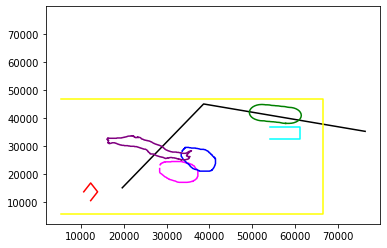

In [5]:
zip_tank = '../../DigiPath_MLTK_data/zipTank/wsi_annotation_sample/'
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

region_id_dict = get_region_Id_dict(xml_name, c_lab_id_fn)

plot_regions(region_id_dict)

In [6]:
    
# Test region Id dict function
# zip_tank = '../../DigiPath_MLTK_data/zipTank/wsi_annotation_sample/'
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

region_id_dict = get_region_Id_dict(xml_name, c_lab_id_fn)
for k_reg_id, v_val in region_id_dict.items():
    print('\n\tregion_Id', k_reg_id)
    for k, v in v_val.items():
        if k == 'coords':
            print('%20s: size = (%i, %i)'%(k, v.shape[0], v.shape[1]), type(v), type(v[0,0]))
        elif k == 'Priority':
            print('%20s: %i'%(k, v))
        else:
            print('%20s: %s'%(k, v))


	region_Id 1
    class_label_text: offset
      class_label_Id: 5
            Priority: 5
    region_geo_shape: Points
              coords: size = (3, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 2
    class_label_text: Region
      class_label_Id: 3
            Priority: 3
    region_geo_shape: Rectangle
              coords: size = (4, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 3
    class_label_text: malignant
      class_label_Id: 4
            Priority: 4
    region_geo_shape: Polygon
              coords: size = (133, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 4
    class_label_text: normal
      class_label_Id: 7
            Priority: 7
    region_geo_shape: Rectangle
              coords: size = (4, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 5
    class_label_text: fat
      class_label_Id: 1
            Priority: 1
    region_geo_shape: Ellipse
              coords: size = (4, 2) <class 'numpy.ndar

In [7]:
# Test Labels Dict function
zip_tank = '../../DigiPath_MLTK_data/zipTank/wsi_annotation_sample/'
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')
lbl_dict = get_labels_dict(c_lab_id_fn)
for k, v in lbl_dict.items():
    print('%20s'%(k), v)
    

                null {'ID': '0', 'Priority': '0'}
                 fat {'ID': '1', 'Priority': '1'}
               lymph {'ID': '2', 'Priority': '2'}
              Region {'ID': '3', 'Priority': '3'}
           malignant {'ID': '4', 'Priority': '4'}
              offset {'ID': '5', 'Priority': '5'}
                 ink {'ID': '6', 'Priority': '6'}
              normal {'ID': '7', 'Priority': '7'}


In [8]:
"""
    Test leads to the assumption that the region_Id is the unique identifier for the annotation xml
"""
# Test get_xml_list_of_dicts function -- view input file fields

# xml_name = os.path.join(zip_tank, '54742d6c5d704efa8f0814456453573a.xml')
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')

lstod = get_xml_list_of_dicts(xml_name)
keys_list = list(lstod[0].keys())
count = 0
print('\t'.join(keys_list), '\n')
for l in lstod:
    # print(type(l), len(l))
    for k in keys_list:
        if not k in l:
            print('Crash Crash %i not in %i'%(k, count))
        elif k == 'coords':
            print(l['region_Id'], l['class_label_text'], l['class_label_Id'], '\t\t', len(l[k]), '\t', type(l[k]))
        elif k == 'region_geo_shape':
            print(l['region_geo_shape'])
    count += 1
    print()

vertices	region_Id	class_label_text	class_label_Id	region_geo_shape	coords 

Points
1 offset 5 		 3 	 <class 'numpy.ndarray'>

Rectangle
2 Region 3 		 4 	 <class 'numpy.ndarray'>

Polygon
3 malignant 4 		 133 	 <class 'numpy.ndarray'>

Rectangle
4 normal 7 		 4 	 <class 'numpy.ndarray'>

Ellipse
5 fat 1 		 4 	 <class 'numpy.ndarray'>

Area
6 null 0 		 110 	 <class 'numpy.ndarray'>

Polygon
7 lymph 2 		 152 	 <class 'numpy.ndarray'>

Area
8 ink 6 		 619 	 <class 'numpy.ndarray'>




                region_Id: 1
         class_label_text: offset
           class_label_Id: 5
                 Priority: 5
         region_geo_shape: Points


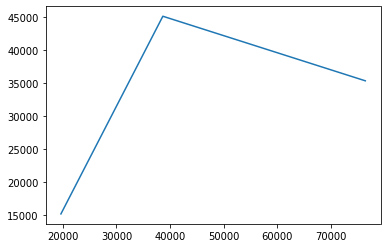


                region_Id: 2
         class_label_text: Region
           class_label_Id: 3
                 Priority: 3
         region_geo_shape: Rectangle


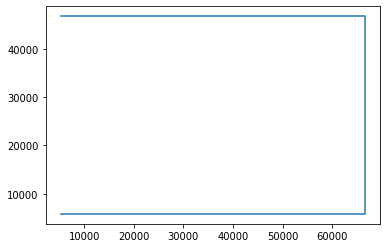


                region_Id: 3
         class_label_text: malignant
           class_label_Id: 4
                 Priority: 4
         region_geo_shape: Polygon


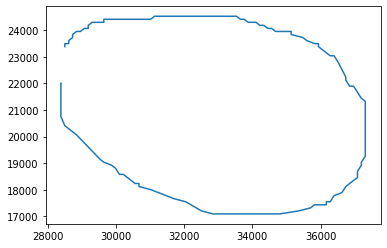


                region_Id: 4
         class_label_text: normal
           class_label_Id: 7
                 Priority: 7
         region_geo_shape: Rectangle


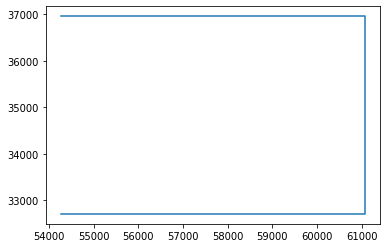


                region_Id: 5
         class_label_text: fat
           class_label_Id: 1
                 Priority: 1
         region_geo_shape: Ellipse


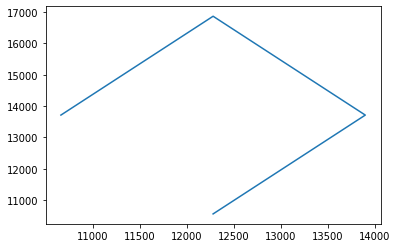


                region_Id: 6
         class_label_text: null
           class_label_Id: 0
                 Priority: 0
         region_geo_shape: Area


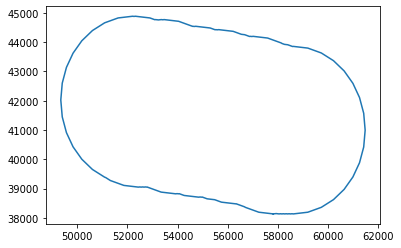


                region_Id: 7
         class_label_text: lymph
           class_label_Id: 2
                 Priority: 2
         region_geo_shape: Polygon


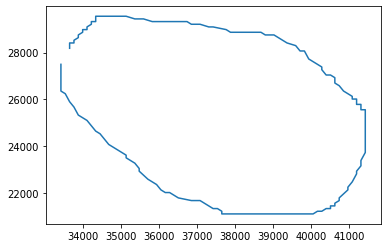


                region_Id: 8
         class_label_text: ink
           class_label_Id: 6
                 Priority: 6
         region_geo_shape: Area


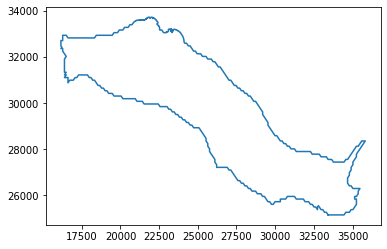

In [9]:
plot_region_shapes_dicts(region_id_dict)

### Question Of the Day text:

`Is each region_Id unique in the .xml input file?` <br>

`Is the Priority field in the class_label_id.csv Exclusive to the highest Label & ID,
or should the overlap with lesser priorities be omitted as ambiguous?` <br>

```
If we can agree that the region_id's have no duplicates within the .xml file,
then a first approximation of priority policy could get region id masks for labeled patches 
and give us graphical selections to look at. 
``` 

`More Complicated Thing to Think About -- training sets:` <br>
```text
    If using an annotated image for classification, 
    need there be any balance by number of patches for each label?
    
    If so what is the protocol for the striding the patches in different sized region masks?
    ( overlap more in small regions, and / or less in large regions ? or with specific priorities etc. )
```

patch.area = 313.6548490545939


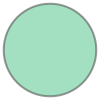

In [10]:
from shapely.geometry import Point
patch = Point(0.0, 0.0).buffer(10.0)
print('patch.area =',patch.area)
patch

{"type": "Point", "coordinates": [0.0, 0.0]}


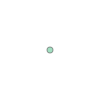

In [11]:
import json
from shapely.geometry import mapping, shape
s = shape(json.loads('{"type": "Point", "coordinates": [0.0, 0.0]}'))
print(json.dumps(mapping(s)))
s

In [12]:
import shapely
help(shapely.geometry)

Help on package shapely.geometry in shapely:

NAME
    shapely.geometry - Geometry classes and factories

PACKAGE CONTENTS
    base
    collection
    geo
    linestring
    multilinestring
    multipoint
    multipolygon
    point
    polygon
    proxy

CLASSES
    builtins.object
        shapely.geometry.base.CAP_STYLE
        shapely.geometry.base.JOIN_STYLE
    shapely.geometry.base.BaseGeometry(builtins.object)
        shapely.geometry.linestring.LineString
            shapely.geometry.polygon.LinearRing
        shapely.geometry.point.Point
        shapely.geometry.polygon.Polygon
    shapely.geometry.base.BaseMultipartGeometry(shapely.geometry.base.BaseGeometry)
        shapely.geometry.collection.GeometryCollection
        shapely.geometry.multilinestring.MultiLineString
        shapely.geometry.multipoint.MultiPoint
        shapely.geometry.multipolygon.MultiPolygon
    
    class CAP_STYLE(builtins.object)
     |  Data descriptors defined here:
     |  
     |  __dict__
     |

In [13]:
from shapely.geometry import LineString

coords = region_id_dict[5]['coords'] # [(0, 0), (1, 1)]
LineString(coords).contains(Point(12281, 10563))

False

In [14]:
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

region_id_dict = get_region_Id_dict(xml_name, c_lab_id_fn)
k_list = list(region_id_dict.keys())
for row in region_id_dict[5]['coords']:
    print(row)


[12280.676903 10562.721013]
[13898.672068 13713.553703]
[12280.676903 16864.386394]
[10662.681737 13713.553703]


In [15]:
from shapely.geometry import mapping, shape
help(mapping)

Help on function mapping in module shapely.geometry.geo:

mapping(ob)
    Returns a GeoJSON-like mapping



<class 'shapely.geometry.polygon.Polygon'>


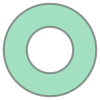

In [16]:
donut = shapely.geometry.Point(0, 0).buffer(2.0).difference(shapely.geometry.Point(0, 0).buffer(1.0))
print(type(donut))
donut

[shapely object.bounds](https://shapely.readthedocs.io/en/latest/manual.html#object.bounds) <br>
[shapely object.contains](https://shapely.readthedocs.io/en/latest/manual.html#object.contains) <br>
[shapely object.centroid](https://shapely.readthedocs.io/en/latest/manual.html#object.centroid) <br>
[shapely object.intersects](https://shapely.readthedocs.io/en/latest/manual.html#object.intersects) <br>
[shapely object.envelope](https://shapely.readthedocs.io/en/latest/manual.html#object.envelope) <br>
[shapely object.overlaps](https://shapely.readthedocs.io/en/latest/manual.html#object.overlaps) <br>
[shapely object.touches](https://shapely.readthedocs.io/en/latest/manual.html#object.touches) <br>
[shapely object.union](https://shapely.readthedocs.io/en/latest/manual.html#object.union) <br>
[shapely object.within](https://shapely.readthedocs.io/en/latest/manual.html#object.within) <br>
****

[point, line, polygon](https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html) <br>

In [17]:
coords = region_id_dict[5]['coords'] # [(0, 0), (1, 1)]
print(LineString(coords).intersects(Point(12281, 10563)))
print(LineString(coords).contains(Point(12281, 10563)))
# print(LineString(coords).bounds(Point(12281, 10563)))
# print(LineString(coords).centroid(Point(12281, 10563)))
print( type(LineString(coords).union(Point(12281, 10563)) ))
# print(LineString(coords).envelope(Point(12281, 10563)))
print(LineString(coords).overlaps(Point(12281, 10563)))
print(LineString(coords).touches(Point(12281, 10563)))
print(LineString(coords).within(Point(12281, 10563)))

False
False
<class 'shapely.geometry.collection.GeometryCollection'>
False
False
False


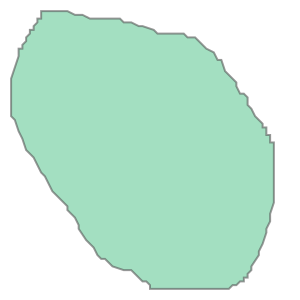

In [18]:
from shapely.geometry import Polygon
poly = Polygon(region_id_dict[7]['coords'])
display(poly)

1


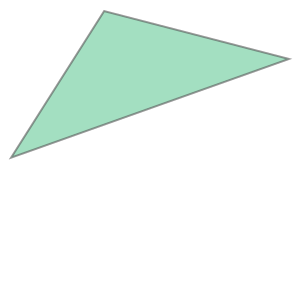

2


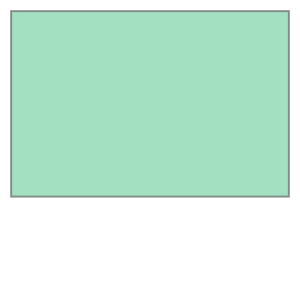

3


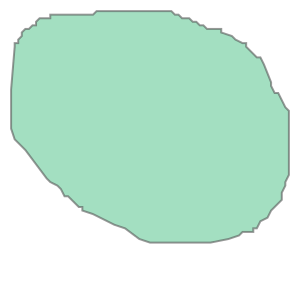

4


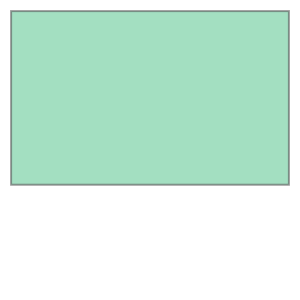

5


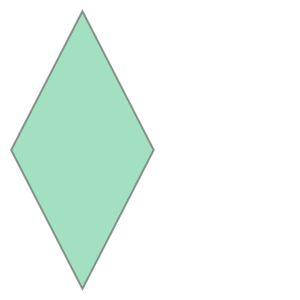

6


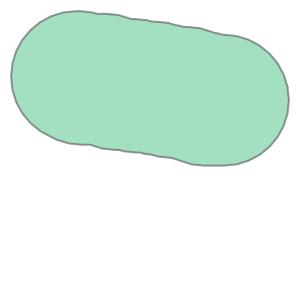

7


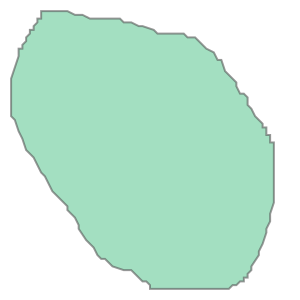

8


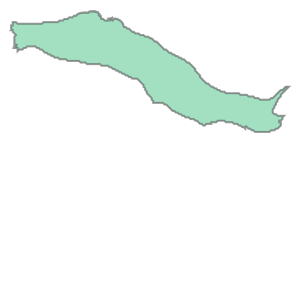

In [19]:
for zb_idx in range(len(region_id_dict)):
    idx = zb_idx + 1
    print(idx)
    display(Polygon(region_id_dict[idx]['coords']))

In [21]:
import openslide
from PIL import Image
from PIL import ImageDraw

In [31]:
im_dir = '../../DigiPath_MLTK_data/RegistrationDevData'
im_file = '54742d6c5d704efa8f0814456453573a.tiff'
os.listdir(im_dir)

['e39a8d60a56844d695e9579bce8f0335.tiff',
 '54742d6c5d704efa8f0814456453573a.tiff',
 'wsi_pair_sample.csv']

(727, 419) (145408, 83968)


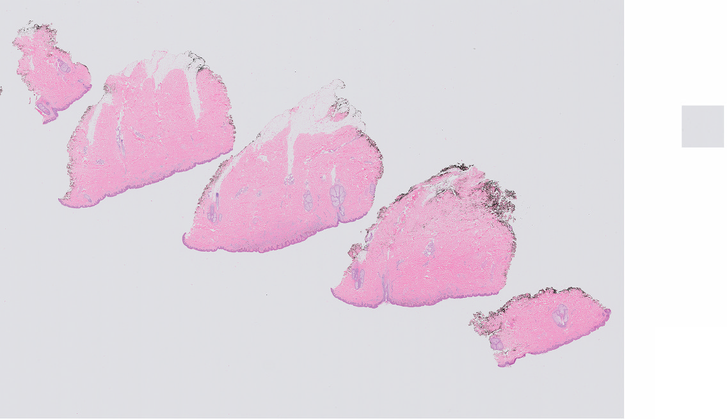

In [93]:
image_file_name = os.path.join(im_dir, im_file)
os_obj = openslide.OpenSlide(image_file_name)
thumbie = os_obj.get_thumbnail((727, 419))
print(thumbie.size, os_obj.dimensions)
im2 = thumbie.copy().convert('RGBA')
drw = ImageDraw.Draw(im2)
    
drw.polygon(xy_list, fill="blue")

display(thumbie)
os_obj.close()

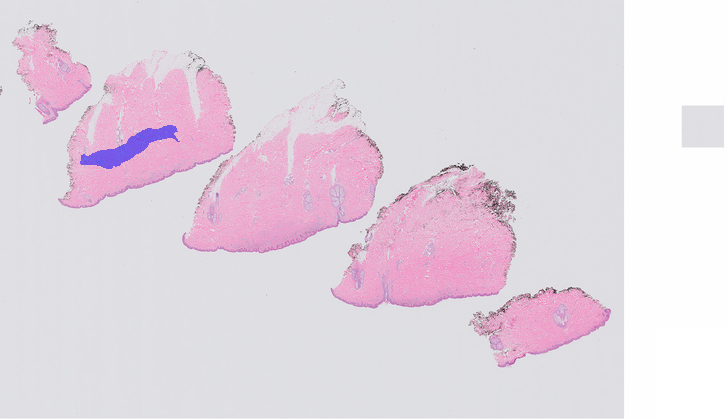

In [89]:
xy = region_id_dict[8]['coords'] / 200

x = xy[:,0].astype(np.int)
y = xy[:,1].astype(np.int)
xy_list = []
for x, y in zip(x, y):
    xy_list.append((x,y))
    
im2 = thumbie.copy().convert('RGBA')
drw = ImageDraw.Draw(im2)

# print(xy.shape, im2.size)
# for x, y in zip(x,y):
#     print(x, y)
    
drw.polygon(xy_list, fill="blue")

img3 = Image.blend(thumbie, im2.convert('RGB'), 0.5)
# # # img3.save('/tmp/out.png')
display(img3)


<class 'PIL.Image.Image'>


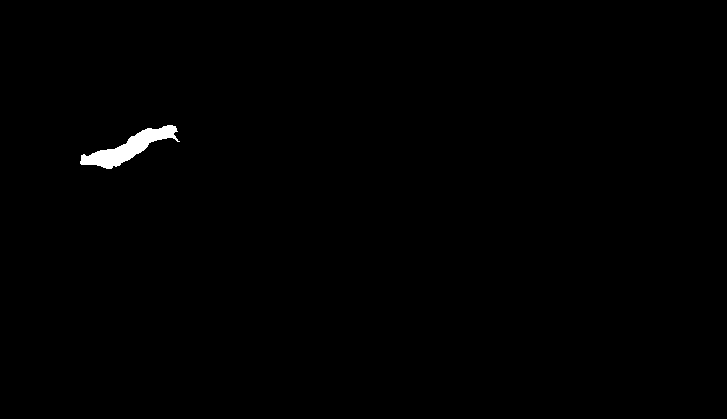

In [128]:
def get_region_mask(region_coords, thumbnail_divisor, image_dimensions):
    """ mask_im, img = get_region_mask(region_coords, thumbnail_divisor, image_dimensions) """
    xy_list = (region_coords / thumbnail_divisor).astype(np.int).tolist()
    xy_list = [(p[0], p[1]) for p in xy_list ]
    
    thumbnail_size = tuple((np.array(image_dimensions) / thumbnail_divisor).astype(np.int))
    num_thumb_size = (thumbnail_size[1], thumbnail_size[0])
    
    img = Image.fromarray(np.zeros(num_thumb_size).astype(np.uint8))
    
    drw = ImageDraw.Draw(img)
    drw.polygon(xy_list, fill="white")
    
    mask_im = np.array(img) > 0
    
    return mask_im, img

region_coords = region_id_dict[8]['coords']
thumbnail_divisor = 200
# os_obj = openslide.OpenSlide(image_file_name)
# image_dimensions = os_obj.dimensions
# os_obj.close()
mask_im, img = get_region_mask(region_coords, thumbnail_divisor, image_dimensions)

print(type(img))
display(img)

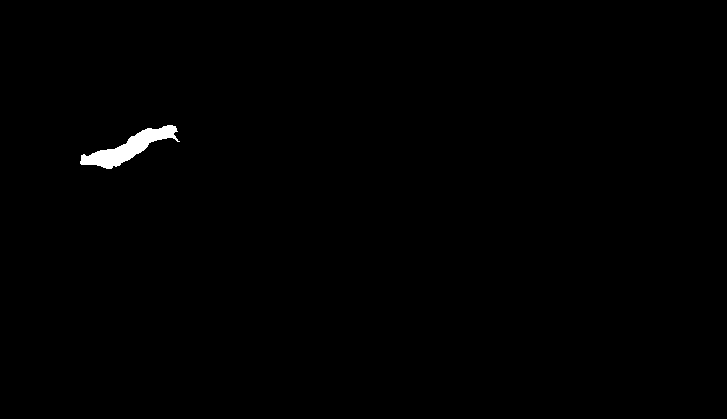

In [122]:
thumbnail_divisor = 200
os_obj = openslide.OpenSlide(image_file_name)

# xy = region_id_dict[8]['coords'] / thumbnail_divisor
xy_list = (region_id_dict[8]['coords'] / thumbnail_divisor).astype(np.int).tolist()
xy_list = [(p[0], p[1]) for p in xy_list ]

thumbnail_size = tuple((np.array(os_obj.dimensions) / thumbnail_divisor).astype(np.int))

# thumbie = os_obj.get_thumbnail(thumbnail_size)
num_thumb_size = (thumbnail_size[1], thumbnail_size[0])
im2 = Image.fromarray(np.zeros(num_thumb_size).astype(np.uint8))
# im2 = mask_im.copy().convert('L')
drw = ImageDraw.Draw(im2)

drw.polygon(xy_list, fill="white")


display(im2)
os_obj.close()

In [118]:
print(thumbnail_size)
mask_im = Image.fromarray(np.zeros(thumbnail_size).astype(np.uint8))

(727, 419)


In [51]:
# zip_tank = '../../DigiPath_MLTK_data/zipTank/wsi_annotation_sample/'
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

region_id_dict = get_region_Id_dict(xml_name, c_lab_id_fn)
for k_reg_id, v_val in region_id_dict.items():
    print('\n\tregion_Id', k_reg_id)
    for k, v in v_val.items():
        if k == 'coords':
            print('%20s: size = (%i, %i)'%(k, v.shape[0], v.shape[1]), type(v), type(v[0,0]))
        elif k == 'Priority':
            print('%20s: %i'%(k, v))
        else:
            print('%20s: %s'%(k, v))


	region_Id 1
    class_label_text: offset
      class_label_Id: 5
            Priority: 5
    region_geo_shape: Points
              coords: size = (3, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 2
    class_label_text: Region
      class_label_Id: 3
            Priority: 3
    region_geo_shape: Rectangle
              coords: size = (4, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 3
    class_label_text: malignant
      class_label_Id: 4
            Priority: 4
    region_geo_shape: Polygon
              coords: size = (133, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 4
    class_label_text: normal
      class_label_Id: 7
            Priority: 7
    region_geo_shape: Rectangle
              coords: size = (4, 2) <class 'numpy.ndarray'> <class 'numpy.float64'>

	region_Id 5
    class_label_text: fat
      class_label_Id: 1
            Priority: 1
    region_geo_shape: Ellipse
              coords: size = (4, 2) <class 'numpy.ndar